<a href="https://colab.research.google.com/github/giordanovitale/Prado-Museum-CNN/blob/main/Prado_Artists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   [Data Augmentation Techniques](https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9#8be0)
2.   [Model Architectures](https://medium.com/@navarai/unveiling-the-diversity-a-comprehensive-guide-to-types-of-cnn-architectures-9d70da0b4521)
3. [EfficientNet](https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd5b736142)

Dataset Source: https://www.kaggle.com/datasets/maparla/prado-museum-pictures

# 0 - Load the necessary libraries

In [ ]:
!pip install visualkeras

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import polars as pl

import tqdm
import os
import requests

from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import visualkeras as vk

from scipy.optimize import fsolve
from math import exp
import matplotlib.pyplot as plt

from collections import defaultdict

from google.colab import userdata

import keras.backend as K
from keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    AveragePooling2D, BatchNormalization, ReLU, PReLU, ZeroPadding2D, \
    GlobalAveragePooling2D, Input, DepthwiseConv2D, Add, Activation, Lambda, RandomFlip, \
    Rescaling, RandomContrast, RandomZoom, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preproccessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preproccessing
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preproccessing
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing

# Get rid of the extra stuff that gets downloaded
!rm -rf sample_data

In [3]:
INPUT_SHAPE = (224,224,3)

# 1 - Helper Functions

In [29]:
def download_url(args):
    """
    Downloads a file from an url
    :param args: Tuple containing the url and filename
    :return: None
    """
    url, filename = args[0], args[1]
    try:
      r = requests.get(url)
      if r.status_code != 404:
        with open(filename, "wb") as f:
          f.write(r.content)

    except Exception as e:
      print("Exception in download_url():", e)

In [34]:
def download_parallel(args):
    """
    Downloads urls in parallel
    :param args: List of tuples containing the url and filename
    :return: None
    """
    cpus = cpu_count()
    threadpool = ThreadPool(cpus)
    with tqdm.tqdm(total=len(args), desc="Downloading images") as pbar:
        for _ in threadpool.imap_unordered(download_url, args):
            pbar.update(1)
    threadpool.close()
    threadpool.join()

# 2 - Load the dataset using Kaggle API

My Username and Key have been secreted. Replace `userdata.get('KAGGLE_USERNAME')` and `userdata.get('KAGGLE_KEY')`with your username and key, respectively.

In [24]:
os.environ["KAGGLE_USERNAME"] = "userdata.get('KAGGLE_USERNAME')"
os.environ["KAGGLE_KEY"] = "userdata.get('KAGGLE_KEY')"
!kaggle datasets download maparla/prado-museum-pictures -f prado.csv
!unzip prado.csv.zip

Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
prado.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  prado.csv.zip
replace prado.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Create the dataframe from the unzipepd csv file.

In [4]:
df = pd.read_csv(os.path.join("prado.csv"))

Since no target class has been defined from the project assignment, I have to decide it. After a careful inspection of the columns, I found out that the more suitable ones are `author` and `technical_sheet_tecnica`. The latter seems more intriguing as it has more observations, thus being more suitable to big data algorithms.

In [141]:
df['author'].value_counts()

author
Anónimo                                                                       2698
Goya y Lucientes, Francisco de                                                1080
Bayeu y Subías, Francisco                                                      446
Haes, Carlos de                                                                326
Pizarro y Librado, Cecilio                                                     290
                                                                              ... 
Malombra, Pietro                                                                 1
Taller de Bellini, Giovanni                                                      1
Mattioli, Ludovico -Dibujante- (Autor de la obra original: Cignani, Carlo)       1
Ricci, Marco                                                                     1
García, Sergio                                                                   1
Name: count, Length: 2560, dtype: int64

In [142]:
df['technical_sheet_tecnica'].value_counts().sort_values(ascending=False)[:10]

Exception in download_url(): [Errno 2] No such file or directory: 'data/pencil/59825391-c4b9-4f84-8d6f-413fa045a3ea.jpg'


technical_sheet_tecnica
Óleo                    4156
Acuñación               1118
Esculpido                550
Lápiz compuesto          476
Clarión; Lápiz negro     396
Albúmina                 395
Sanguina                 372
Lápiz                    259
Lápiz negro              237
Pluma; Tinta parda       214
Name: count, dtype: int64

Reduce the data set by keeping observations belonging to the 4 classes of interest only.

In [5]:
df = df[df['technical_sheet_tecnica'].isin(['Óleo',
                                            'Acuñación',
                                            'Esculpido',
                                            'Lápiz compuesto'])]

In [7]:
df.shape

(6300, 30)

In order to obtain the JPGs images, we need to start from the given URL column `work_image_url`.

In [6]:
df['work_id'] = df['work_image_url'].apply(lambda x: x.split('/')[-1])

Create the folders into which the images will be stored, according to their respective class.

The important columns are:
`['work_image_url', 'work_id', 'technical_sheet_tecnica']`

In [7]:
!mkdir data

In [7]:
esp_techniques = ['Óleo', 'Acuñación', 'Esculpido', 'Lápiz compuesto']
eng_techniques = ['oil', 'minting', 'sculpture', 'pencil']

In [19]:
# rm -rf data

In [21]:
for technique in eng_techniques:
  !mkdir -p data/$technique

In [7]:
!mkdir model_logs

In [31]:
download_list = list()

for esp_technique, eng_technique in zip(esp_techniques, eng_techniques):

  image_urls = list(df['work_image_url'].loc[df['technical_sheet_tecnica'] == esp_technique])
  image_names = list(df['work_id'].loc[df['technical_sheet_tecnica'] == esp_technique])
  image_names = [f"data/{eng_technique}/" + fn for fn in image_names]

  for url, fn in zip(image_urls, image_names):
    download_list.append((url, fn))

In [32]:
len(download_list)

6300

In [35]:
download_parallel(download_list)

## Class Imbalance

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [8]:
num_oils = df.loc[df['technical_sheet_tecnica']=='Óleo'].shape[0]
num_mintings = df.loc[df['technical_sheet_tecnica']=='Acuñación'].shape[0]
num_sculptures = df.loc[df['technical_sheet_tecnica']=='Esculpido'].shape[0]
num_pencils = df.loc[df['technical_sheet_tecnica']=='Lápiz compuesto'].shape[0]

num_total = df.shape[0]

In [9]:
class_weights = {
    0: num_oils/num_total,
    1: num_mintings/num_total,
    2: num_sculptures/num_total,
    3: num_pencils/num_total
}

class_weights

{0: 0.6596825396825396,
 1: 0.17746031746031746,
 2: 0.0873015873015873,
 3: 0.07555555555555556}

# 3 - Temporarily use loaded data and mount

In [10]:
import os
import sys
from google.colab import drive

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/AMD")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data  model_logs  Prado-Artists.ipynb  prado.csv  prado.csv.zip


In [11]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/AMD/data',
                                                                label_mode='int',
                                                                color_mode='rgb',
                                                                batch_size=32,
                                                                image_size=(224, 224),
                                                                shuffle=True,
                                                                seed=42,
                                                                validation_split=0.2,
                                                                subset='both',
                                                                labels='inferred',
                                                                class_names=['oil', 'minting', 'sculpture', 'pencil'])

Found 5935 files belonging to 4 classes.
Using 4748 files for training.
Using 1187 files for validation.




---



https://www.tensorflow.org/tutorials/images/data_augmentation

From the link above:

> Note: Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).



In [12]:
num_classes = 4

***

# 4 - Model 1: ZFNet

In [23]:
zfnet = Sequential([

    # Preprocessing layers
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomRotation(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Rotation'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.1),
                               input_shape=INPUT_SHAPE,
                               name='Random_Zoom'),


    # 1st convolutional block
    Conv2D(filters=48,
           kernel_size=(7,7),
           strides=(2,2),
           padding='valid',
           activation=None,
           name='Conv_1'),
    ReLU(name='ReLU_1'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_1'),

    # 2nd convolutional block
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='valid',
           activation=None,
           name='Conv_2'),
    ReLU(name='ReLU_2'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_2'),

    # 3rd convolutional block
    Conv2D(filters=192,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.1'),
    ReLU(name='ReLU_3.1'),
    Conv2D(filters=384,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.2'),
    ReLU(name='ReLU_3.2'),
    Conv2D(filters=192,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.3'),
    ReLU(name='ReLU_3.3'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_3'),

    # Flatten Layer
    Flatten(name='Flatten'),

    # 1st Dense Layer
    Dense(units=256,
          activation='relu',
          name='Dense_1'),

    # 2nd Dense Layer
    Dense(units=256,
          activation='relu',
          name='Dense_2'),

    # 3rd Dense Layer
    Dense(units=num_classes,
          activation='softmax',
          name="Output")
],
    name='ZFNet')

In [24]:
zfnet.build(input_shape=(None, *INPUT_SHAPE))
zfnet.summary()

Model: "ZFNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Random_Zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                             

Model compiling.

In [25]:
zfnet.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

Create csv logger to save the results in case it stops.

In [26]:
zfnet_csv_logger = CSVLogger("/content/model_logs/zfnet.log")

Train the model.

In [ ]:
zfnet_history = zfnet.fit(train_ds,
                          epochs=30,
                          steps_per_epoch=len(train_ds),
                          validation_data=test_ds,
                          validation_steps=len(test_ds),
                          class_weight=class_weights,
                          callbacks=zfnet_csv_logger)

# 5 - Model 2: My Own Proposal

In [36]:
gionet = Sequential([

    # Preprocessing layers
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomRotation(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Rotation'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.1),
                               input_shape=INPUT_SHAPE,
                               name='Random_Zoom'),
    tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                           name="Per_image_standardisation"),


    # 1st convolutional block
    Conv2D(filters=224,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_1'),
    ReLU(name='ReLU_1'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_1'),


    # 2nd convolutional block
    Conv2D(filters=112,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_2'),
    ReLU(name='ReLU_2'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_2'),

    # 3rd convolutional block
    Conv2D(filters=56,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_3'),
    ReLU(name='ReLU_3'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_3'),

    # 4th convolutional block
    Conv2D(filters=28,
           kernel_size=(5,5),
           strides=(1,1),
           padding='same',
           activation=None,
           name='Conv_4.1'),
    ReLU(name='ReLU_4.1'),
    Conv2D(filters=28,
           kernel_size=(5,5),
           strides=(1,1),
           padding='same',
           activation=None,
           name='Conv_4.2'),
    ReLU(name='ReLU_4.2'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='valid',
                     name='Avg_Pooling_4'),

    # Flatten Layer
    Flatten(name='Flatten'),

    # 1st Dense Layer
    Dense(units=64,
          activation='relu',
          name='Dense_1'),

    # 2nd Dense Layer
    Dense(units=num_classes,
          activation='softmax',
          name="Output")
],
    name='GioNet')

In [37]:
gionet.build(input_shape=(None, *INPUT_SHAPE))
gionet.summary()

Model: "GioNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Random_Zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                            

Compile the model

In [18]:
gionet.compile(loss=SparseCategoricalCrossentropy(),
               optimizer=Adam(),
               metrics=['accuracy'])

CSV logger in case it stops.

In [19]:
gionet_csv_logger = CSVLogger("/content/drive/MyDrive/AMD/model_logs/gionet.log")

Train the model.

In [20]:
gionet_history = gionet.fit(train_ds,
                            epochs=30,
                            steps_per_epoch=len(train_ds),
                            validation_data=test_ds,
                            validation_steps=len(test_ds),
                            class_weight=class_weights,
                            callbacks=gionet_csv_logger)

Epoch 1/30
  2/149 [..............................] - ETA: 55:53 - loss: 0.6947 - accuracy: 0.2969      

KeyboardInterrupt: 

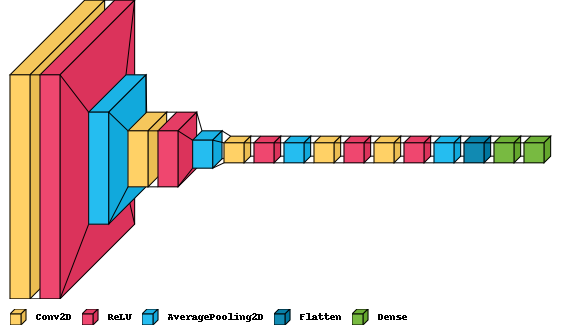

In [43]:
color_map = defaultdict(dict)

# Assign the same color to all the preprocessing steps
color_map[Rescaling]["fill"] = "#3785CD"
color_map[RandomFlip]["fill"] = "#3785CD"
color_map[RandomRotation]["fill"] = "#3785CD"
color_map[RandomContrast]["fill"] = "#3785CD"
color_map[RandomZoom]["fill"] = "#3785CD"
color_map[Lambda]["fill"] = "#3785CD"


color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(gionet,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

# 6 - Third Model

# Save the folders

In [40]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source_path = '/content/data'
destination_path = '/content/drive/My Drive/AMD/data'

# Copy the folder to Google Drive
shutil.copytree(source_path, destination_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/AMD/data'